These are all the imports from python libraries and landlab components

In [54]:
import numpy as np
import matplotlib.pyplot as plt #For plotting results; optional

## Import Landlab components
#Pit filling; optional
from landlab.components import DepressionFinderAndRouter
#Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator instead of FlowRouter--- router is a deprecated component for landlab
#from landlab.components.flow_accum.flow_accumulator import FlowAccumulator
from landlab.components import PriorityFloodFlowRouter
#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import FastscapeEroder 

from landlab.components import SinkFillerBarnes

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results; optional
from landlab.io import read_esri_ascii
from landlab.io import read_asc_header 
%matplotlib inline

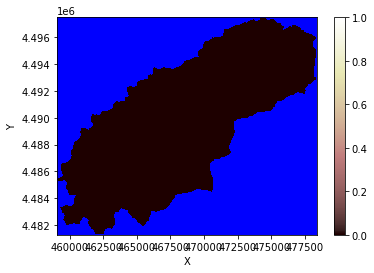

In [55]:
#Set directory paths to retrieve the asc file
path_project = r"C:/Users/gsbir/Documents/EES_393/" # add the path to the asc file    #this should access my H drive
filename_dem = "saucon_txt.txt" #the name of the asc file
path_dem = path_project + filename_dem

#now read the header of the asc file (where there is ncols nrows cell size and nodata value)
dem_header = read_asc_header(open(path_dem, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(path_dem, name= 'topographic__elevation', halo = 1)

#set the watershed boundary condition and plot the
mg.set_watershed_boundary_condition(z, nodata_value = -9999)
#This should find your outlet node automatically and

#this lin can look at the coundary status of the nodes to see where the outlet is
imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue')

## Run the following 2 lines if above method gives multiple watershed outlet options.
outlet_node_ID = 0 #use the specific node index that you know should be your outlet.
mg.set_watershed_boundary_condition_outlet_id(outlet_node_ID ,mg['node']['topographic__elevation'], -9999.)

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False)
sfb.run_one_step()#This is important to ensure that your future flow routing will work properly.

#You can then plot everything in your preferred way
#imshow_grid(mg, 'topographic__elevation', cmap='terrain', color_for_closed="grey")


 


In [56]:
#Set grid parameters
num_rows = 712
num_columns = 595
node_next_to_outlet = num_columns + 1
node_spacing = 27.097698258644

#Set model timestep
timestep = 5 #years

#Set model run time
run_time = 100 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation'
#to yield 'topographic elevation'
mg.at_node['bedrock__elevation'][:] = mg.at_node['topographic__elevation'] - mg.at_node['soil__depth']
#mg.at_node['topographic__elevation'][:] += mg.at_node['soil__depth']


#Set grid parameters
num_rows = 20
num_columns = 20
node_next_to_outlet = num_columns + 1
node_spacing = 100.0

#Set model timestep
timestep = 1.0 #years

#Set model run time
run_time = 100 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')

#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)

## Create initial model topography
#plane tilted towards the lower−left corner
topo = mg.node_y/100000 + mg.node_x/100000

#topographic roughness
random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid
mg['node']['topographic__elevation'] += (topo + random_noise) 

#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation'
#to yield 'topographic elevation'
mg.at_node['bedrock__elevation'][:] = mg.at_node['topographic__elevation'] 
mg.at_node['topographic__elevation'][:] += mg.at_node['soil__depth']


This section is to set the boundaries of the grid

In [57]:
#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                       left_is_closed=True,
                                       right_is_closed=True,
                                       top_is_closed=True)

#Set lower-left (southwest) corner as an open boundary
#mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)


In [58]:
#Instantiate flow router
#fr = FlowAccumulator(mg, flow_director='D8')        #changed this to FlowAccumulator
#flow_director='D8' was previously a parameter of the above function call
#Instantiate depression finder and router; optional

fr = PriorityFloodFlowRouter(mg,surface='topographic__elevation', flow_metric='D8', runoff_rate=None, update_flow_depressions=True, depression_handler='fill', exponent=1, epsilon=False, accumulate_flow=True, accumulate_flow_hill=False, separate_hill_flow=False, update_hill_depressions=False, update_hill_flow_instantaneous=False, hill_flow_metric='D8', hill_exponent=1, suppress_out=False)
#fr = PriorityFloodFlowRouter(mg, )
df = DepressionFinderAndRouter(mg)

#Instantiate SPACE model with chosen parameters    , method='simple_stream_power'
sp = Space(mg, K_sed=0.01, K_br=0.001, F_f=0., phi=0., H_star=1., v_s=5.0, m_sp=0.5, n_sp=1.0, sp_crit_sed=0, sp_crit_br=0)

In [59]:
#Set elapsed time to zero
elapsed_time = 0 #years

#Set timestep count to zero
count = 0

#Array to save sediment flux values
#sed_flux = np.zeros(int(run_time // timestep))
sed_flux = [0] * (run_time)                                 ###added this instead of the previous line
while elapsed_time < run_time: #time units of years
    mg.at_node['bedrock__elevation'] += uplift_per_timestep 
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth']
    
    #df.map_depressions()
    #Run the flow router
    fr.run_one_step()
    
    
    #Run the depression finder and router; optional
    
    #Get list of nodes in depressions; only
    #used if using DepressionFinderAndRouter
    flooded = np.where(df.flood_status==3)[0]
    sp.run_one_step(dt = timestep) #had to delete flooded_nodes=flooded

    #Save sediment flux value to array
    sed_flux[count] = mg.at_node['sediment__flux'][node_next_to_outlet]
    
    #Add to value of elapsed time
    elapsed_time += timestep
    
    print(count)
    #Increase timestep count
    count += 1

0
1
2
3
4
5
6
7


C:\Users\gsbir\anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\components\space\space.py:763: RuntimeWarning: overflow encountered in exp
  dRdt = -a * np.exp(-b * H)
C:\Users\gsbir\anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\components\space\space.py:591: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dR[idx] = quad(_dRdt, 0, dt, args)[0]


8


C:\Users\gsbir\anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\components\space\space.py:409: RuntimeWarning: overflow encountered in exp
  self._Es = self._sed_erosion_term * (1.0 - np.exp(-H_over_Hstar))
C:\Users\gsbir\anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\components\space\space.py:411: RuntimeWarning: overflow encountered in exp
  self._Er = self._br_erosion_term * np.exp(-H_over_Hstar)


9


30 seconds per year with saucon watershed

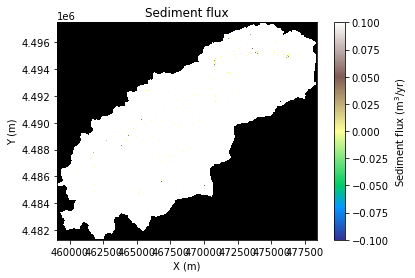

In [60]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='terrain')

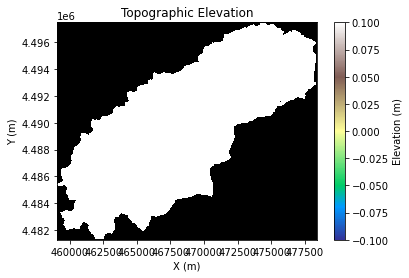

In [61]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

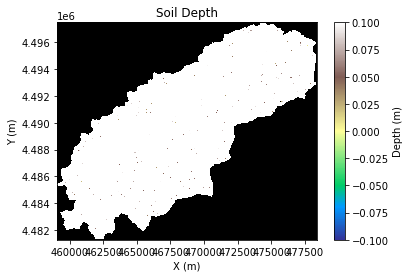

In [62]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'soil__depth', plot_name='Soil Depth', var_name = 'Depth', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

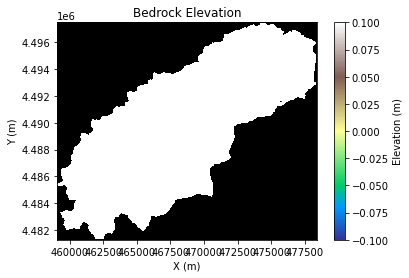

In [63]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'bedrock__elevation', plot_name='Bedrock Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

In [64]:
#Export figure to image
fig.savefig('sediment_flux_map.eps')

Text(0, 0.5, 'Sediment flux [m$^3$/yr]')

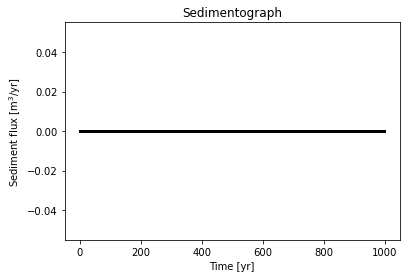

In [65]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
sedfluxplot = plt.subplot()

#Plot data
sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3) ###Changed the arange(_) value from 500 to 400

#Add axis labels
sedfluxplot.set_title('Sedimentograph')
sedfluxplot.set_xlabel('Time [yr]')
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]')

In [66]:
#Export figure to image
fig.savefig('sedimentograph.eps')